## Data Preprocessing

In [4]:
import pandas as pd

file_path = "dataset.xlsx"
sheet_names = ["DATA IB", "DATA IK", "DATA KM"]

dfs = {}
for sheet in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    # Hapus kolom "Unnamed" dan kolom yang kosong
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df = df.dropna(how="all", axis=1)
    
    # Ganti nilai '\N' dengan NaN (null)
    df.replace(r"\\N", pd.NA, inplace=True, regex=True)
    
    dfs[sheet] = df

# Preprocessing untuk setiap sheet
for sheet, df in dfs.items():
    if sheet in ["DATA IB", "DATA IK"]:
        # Konversi waktu dan buat fitur durasi
        df["rencana_berangkat"] = pd.to_datetime(df["rencana_berangkat"], errors="coerce")
        df["rencana_kembali"] = pd.to_datetime(df["rencana_kembali"], errors="coerce")
        df["realisasi_berangkat"] = pd.to_datetime(df["realisasi_berangkat"], errors="coerce")
        df["realisasi_kembali"] = pd.to_datetime(df["realisasi_kembali"], errors="coerce")
        df["durasi"] = (df["rencana_kembali"] - df["rencana_berangkat"]).dt.total_seconds() / 3600  # Dalam jam
        
        # day columns
        df["hari_berangkat"] = df["rencana_berangkat"].dt.day_name()
        df["hari_kembali"] = df["rencana_kembali"].dt.day_name()
        
        # Tambahkan range waktu
        df["range_waktu"] = pd.cut(
            df["rencana_berangkat"].dt.hour,
            bins=[0, 6, 12, 18, 24],
            labels=["Malam", "Pagi", "Siang", "Sore"],
            right=False,
        )
    elif sheet == "DATA KM":
        # Konversi waktu dan buat fitur durasi
        df["tanggal_keluar"] = pd.to_datetime(df["tanggal_keluar"], errors="coerce")
        df["tanggal_masuk"] = pd.to_datetime(df["tanggal_masuk"], errors="coerce")
        df["durasi"] = (df["tanggal_masuk"] - df["tanggal_keluar"]).dt.total_seconds() / 3600  # Dalam jam
        
        # Tambahkan kolom hari
        df["hari_keluar"] = df["tanggal_keluar"].dt.day_name()
        df["hari_masuk"] = df["tanggal_masuk"].dt.day_name()
        
        # Tambahkan range waktu
        df["range_waktu"] = pd.cut(
            df["tanggal_keluar"].dt.hour,
            bins=[0, 6, 12, 18, 24],
            labels=["Malam", "Pagi", "Siang", "Sore"],
            right=False,
        )

# combining all df
combined_df = pd.concat([df.assign(izin=sheet) for sheet, df in dfs.items()], ignore_index=True)

# Simpan hasil preprocessing ke CSV
combined_df.to_csv("preprocessed_data.csv", index=False)


In [5]:
dataset = pd.read_csv('preprocessed_data.csv')

print('Shape dataset: ', dataset.shape)
print('\nData teratas:\n', dataset.head(10))
print('Informasi dataset: \n', dataset.info())
print('\nStatistik deskriptif: \n', dataset.describe())

/tmp/ipykernel_629/993420318.py:1: DtypeWarning: Columns (2,3,4,5,6,7,9,11,12,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('preprocessed_data.csv')


Shape dataset:  (192410, 20)

Data teratas:
    angk status_akhir    rencana_berangkat      rencana_kembali  \
0  2019        Lulus  2019-11-29 18:30:00  2019-12-01 21:00:00   
1  2019        Lulus  2019-12-13 17:00:00  2019-12-15 21:00:00   
2  2019        Lulus  2019-12-19 08:00:00  2020-01-05 18:00:00   
3  2019        Lulus  2020-01-15 13:00:00  2020-01-26 19:00:00   
4  2019        Lulus  2020-02-14 17:00:00  2020-02-16 21:00:00   
5  2019        Lulus  2020-02-29 10:00:00  2020-03-01 20:00:00   
6  2019        Lulus  2020-03-13 17:00:00  2020-03-15 20:30:00   
7  2019        Lulus  2020-03-21 08:00:00  2020-06-01 20:00:00   
8  2019        Lulus  2022-08-17 07:00:00  2022-08-29 17:00:00   
9  2019        Lulus  2023-02-03 16:30:00  2023-02-05 22:00:00   

                                         desc  \
0                    Ingin Bertemu Orang Tua    
1                    Ingin bertemu orang tua    
2                          Libur akhir tahun    
3                              l

## EDA (Exploratory Data Analytics)

Informasi Dataset: Menampilkan informasi kolom (tipe data, jumlah nilai kosong).

Statistik Deskriptif: Menampilkan statistik ringkasan dataset.

Distribusi Kategori: Visualisasi jumlah data per jenis izin (IB, IK, KM).

Distribusi Durasi: Visualisasi boxplot dan histogram untuk durasi.

Distribusi Berdasarkan Hari: Jumlah izin per hari (Senin, Selasa, dst.).

Korelasi Fitur Numerik: Korelasi antar fitur numerik menggunakan heatmap.

Frekuensi Rentang Waktu: Analisis kapan waktu keberangkatan berdasarkan rentang waktu.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data hasil preprocessing
file_path = "preprocessed_data.csv"
df = pd.read_csv(file_path)

# Pastikan tipe waktu sudah benar
df['rencana_berangkat'] = pd.to_datetime(df['rencana_berangkat'], errors='coerce')
df['rencana_kembali'] = pd.to_datetime(df['rencana_kembali'], errors='coerce')
df['realisasi_berangkat'] = pd.to_datetime(df['realisasi_berangkat'], errors='coerce')
df['realisasi_kembali'] = pd.to_datetime(df['realisasi_kembali'], errors='coerce')
df['tanggal_keluar'] = pd.to_datetime(df['tanggal_keluar'], errors='coerce')
df['tanggal_masuk'] = pd.to_datetime(df['tanggal_masuk'], errors='coerce')

# Eksplorasi Data

# 1. Info dataset
print("Info Dataset:")
print(df.info())

# 2. Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe(include="all"))

/tmp/ipykernel_607/1786503255.py:7: DtypeWarning: Columns (2,3,4,5,6,7,9,11,12,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192410 entries, 0 to 192409
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   angk                 192410 non-null  int64         
 1   status_akhir         192410 non-null  object        
 2   rencana_berangkat    80366 non-null   datetime64[ns]
 3   rencana_kembali      80366 non-null   datetime64[ns]
 4   desc                 78776 non-null   object        
 5   tujuan               80366 non-null   object        
 6   realisasi_berangkat  68857 non-null   datetime64[ns]
 7   realisasi_kembali    61467 non-null   datetime64[ns]
 8   akumulasi_skor       78776 non-null   float64       
 9   nilaiPerilaku        78776 non-null   object        
 10  durasi               192173 non-null  float64       
 11  hari_berangkat       80366 non-null   object        
 12  hari_kembali         80366 non-null   object        
 13  

/tmp/ipykernel_607/2446720818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="izin", palette="Set2")


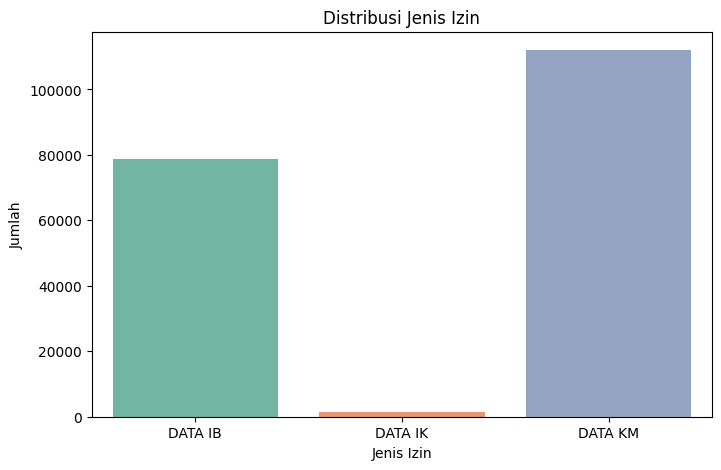

/tmp/ipykernel_607/2446720818.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="izin", y="durasi", palette="Set3")


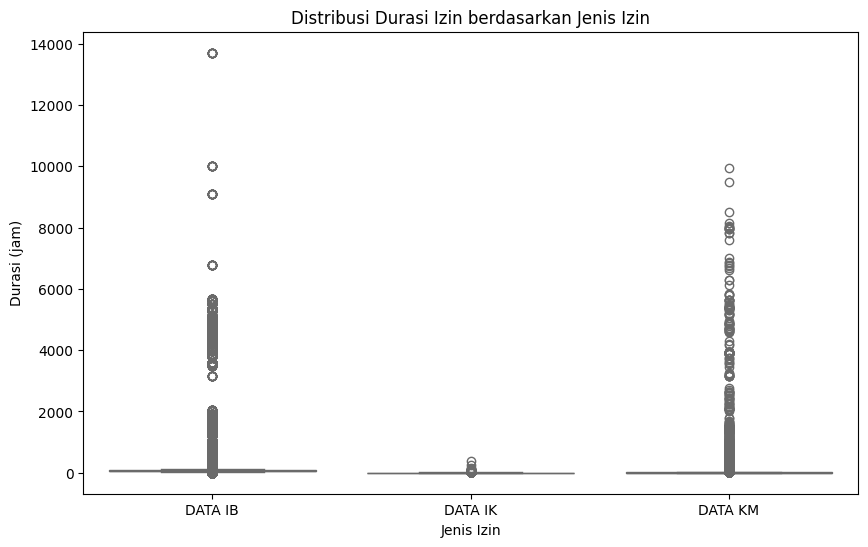

In [2]:
# 3. Distribusi kategori izin
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="izin", palette="Set2")
plt.title("Distribusi Jenis Izin")
plt.xlabel("Jenis Izin")
plt.ylabel("Jumlah")
plt.show()

# 4. Durasi izin berdasarkan jenis izin
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="izin", y="durasi", palette="Set3")
plt.title("Distribusi Durasi Izin berdasarkan Jenis Izin")
plt.xlabel("Jenis Izin")
plt.ylabel("Durasi (jam)")
plt.show()

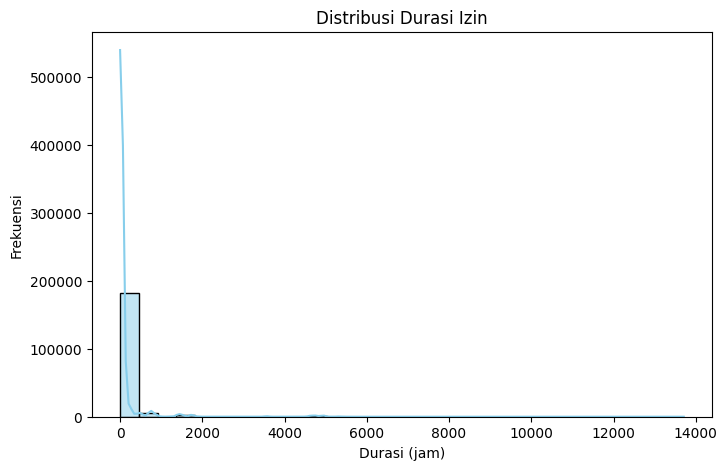

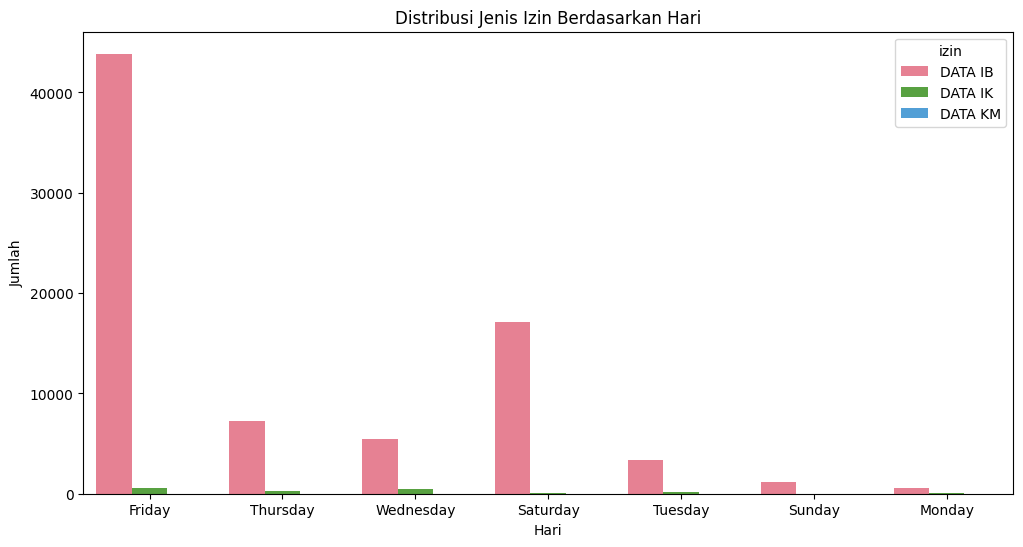

/tmp/ipykernel_607/3211112181.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="hari_keluar", palette="husl")


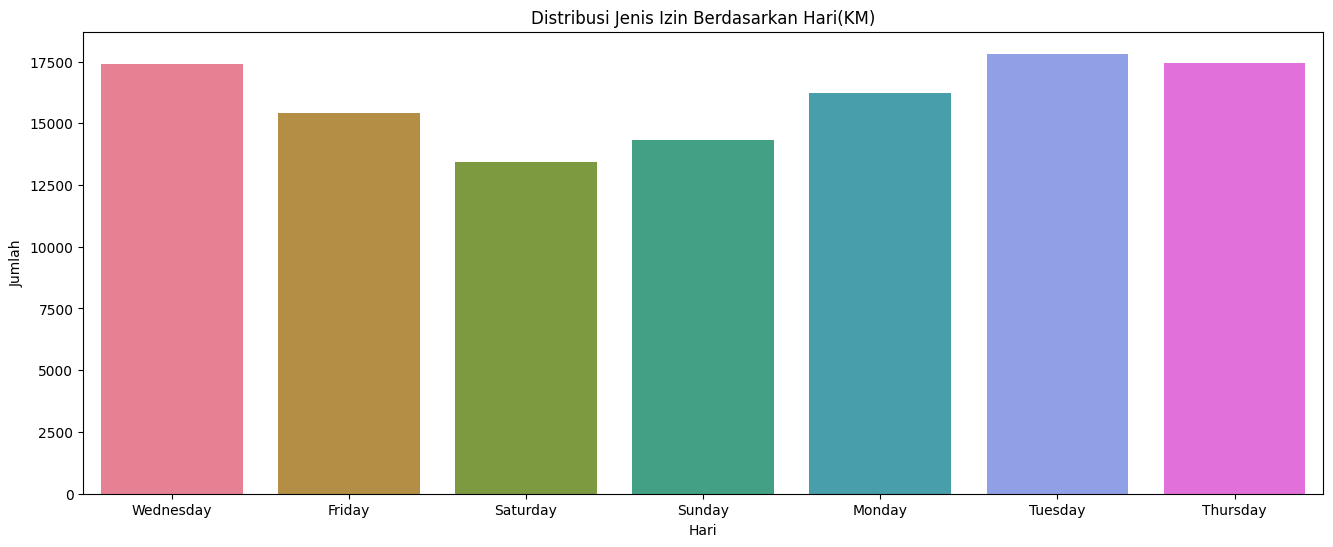

In [10]:
# 5. Distribusi durasi secara keseluruhan
plt.figure(figsize=(8, 5))
sns.histplot(df['durasi'].dropna(), kde=True, bins=30, color="skyblue")
plt.title("Distribusi Durasi Izin")
plt.xlabel("Durasi (jam)")
plt.ylabel("Frekuensi")
plt.show()

# 6. Distribusi izin berdasarkan hari (IB dan IK)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="hari_berangkat", hue="izin", palette="husl")
plt.title("Distribusi Jenis Izin Berdasarkan Hari")
plt.xlabel("Hari")
plt.ylabel("Jumlah")
plt.show()


# 6. Distribusi izin berdasarkan hari (KM)
plt.figure(figsize=(16, 6))
sns.countplot(data=df, x="hari_keluar", palette="husl")
plt.title("Distribusi Jenis Izin Berdasarkan Hari(KM)")
plt.xlabel("Hari")
plt.ylabel("Jumlah")
plt.show()

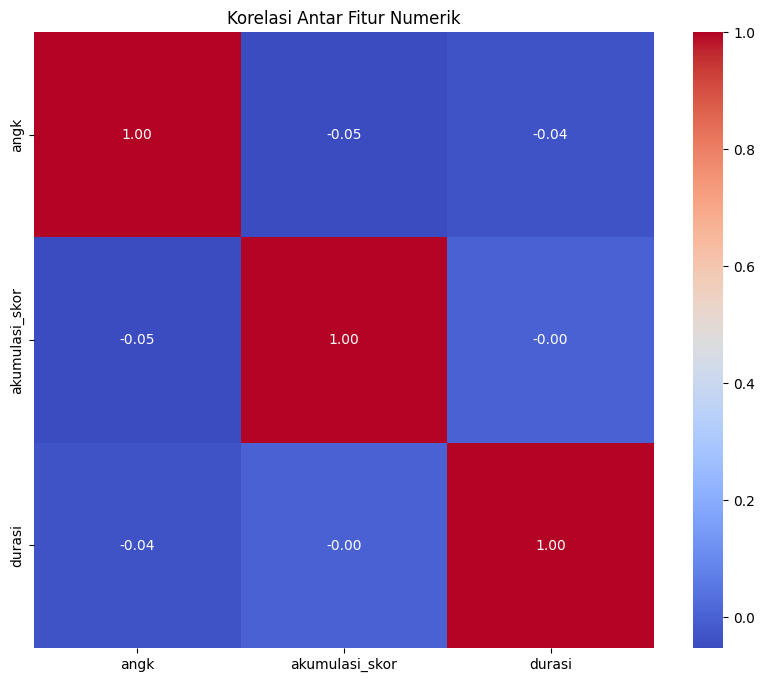

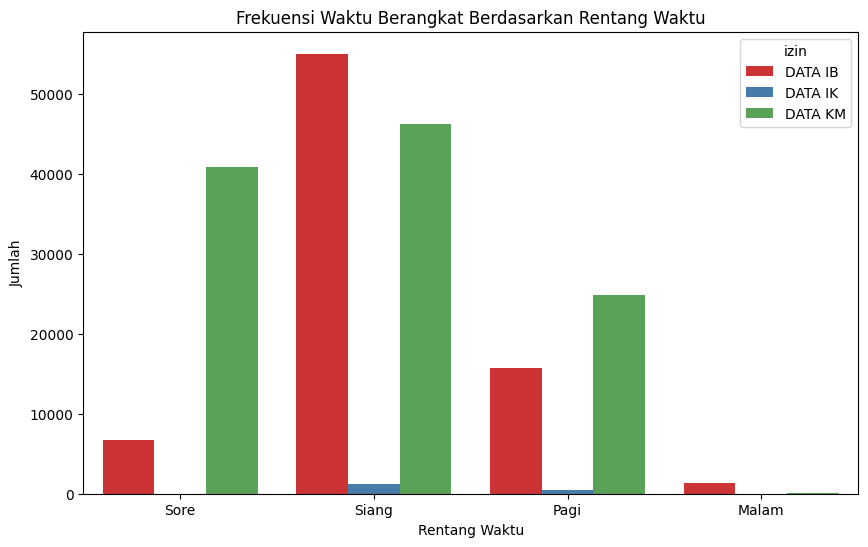

In [5]:
# 7. Korelasi antara fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Korelasi Antar Fitur Numerik")
plt.show()

# 8. Frekuensi waktu berangkat pada rentang waktu
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="range_waktu", hue="izin", palette="Set1")
plt.title("Frekuensi Waktu Berangkat Berdasarkan Rentang Waktu")
plt.xlabel("Rentang Waktu")
plt.ylabel("Jumlah")
plt.show()